# Module 1 — TensorFlow/Keras Basics (Optimized)
**Shallow vs Deep ANN** · **tf.GradientTape & Keras APIs** · **Optimizer & Activation sweeps** · **Decision boundaries**

This notebook refactors duplicate code into clean utilities and produces side‑by‑side decision‑boundary plots for fair comparison.

## 1) Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(7)
tf.random.set_seed(7)


## 2) Synthetic dataset

In [2]:
# Two-moons, scaled
X, y = make_moons(n_samples=1200, noise=0.25, random_state=7)
X = StandardScaler().fit_transform(X).astype('float32')
y = y.astype('float32').reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)
X_train.shape, X_test.shape

((900, 2), (300, 2))

## 3) Core utilities (no duplication)

In [3]:
def build_model(depth='shallow', activation='relu', input_dim=2):
    """Build shallow (1 hidden) or deep (3 hidden) classifier with given activation."""
    act = None if activation=='linear' else activation
    inputs = tf.keras.Input(shape=(input_dim,))
    x = inputs
    if depth == 'shallow':
        x = tf.keras.layers.Dense(16, activation=act)(x)
    else:
        x = tf.keras.layers.Dense(32, activation=act)(x)
        x = tf.keras.layers.Dense(32, activation=act)(x)
        x = tf.keras.layers.Dense(16, activation=act)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs, outputs)

def train_with_tape(model, X, y, optimizer, epochs=300, batch_size=64):
    ds = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(1024).batch(batch_size)
    bce = tf.keras.losses.BinaryCrossentropy()
    history = {'loss':[], 'acc':[]}
    for _ in range(epochs):
        epoch_losses = []
        correct = 0; total = 0
        for xb, yb in ds:
            with tf.GradientTape() as tape:
                preds = model(xb, training=True)
                loss = bce(yb, preds)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            epoch_losses.append(float(loss))
            correct += int(tf.reduce_sum(tf.cast((preds>0.5)==(yb>0.5), tf.int32)))
            total += int(yb.shape[0])
        history['loss'].append(float(np.mean(epoch_losses)))
        history['acc'].append(correct/total)
    return history

def train_with_keras(model, X, y, optimizer='adam', lr=1e-2, epochs=300, batch_size=64, val_data=None):
    opt = optimizer if isinstance(optimizer, tf.keras.optimizers.Optimizer) else getattr(tf.keras.optimizers, optimizer.capitalize())(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    h = model.fit(X, y, validation_data=val_data, epochs=epochs, batch_size=batch_size, verbose=0)
    return h

def decision_boundary(model, X, y, title='Decision boundary', grid=300):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid), np.linspace(y_min, y_max, grid))
    grid_xy = np.c_[xx.ravel(), yy.ravel()].astype('float32')
    Z = (model.predict(grid_xy, verbose=0) > 0.5).astype('int32')
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.35)
    plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=10)
    plt.title(title)

def plot_grid(models, titles, X, y, ncols=3, figsize=(12,8)):
    n = len(models); nrows = int(np.ceil(n/ncols))
    plt.figure(figsize=figsize)
    for i,(m,t) in enumerate(zip(models,titles),1):
        plt.subplot(nrows, ncols, i)
        decision_boundary(m, X, y, t)
    plt.tight_layout(); plt.show()


## 4) Activation comparison (Keras API) — shallow & deep

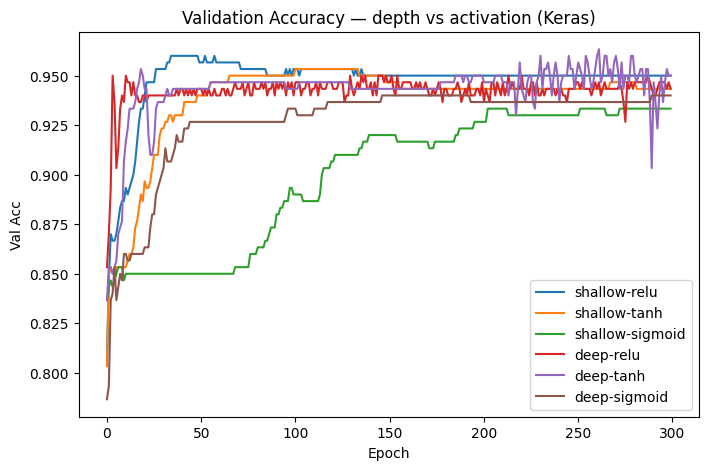

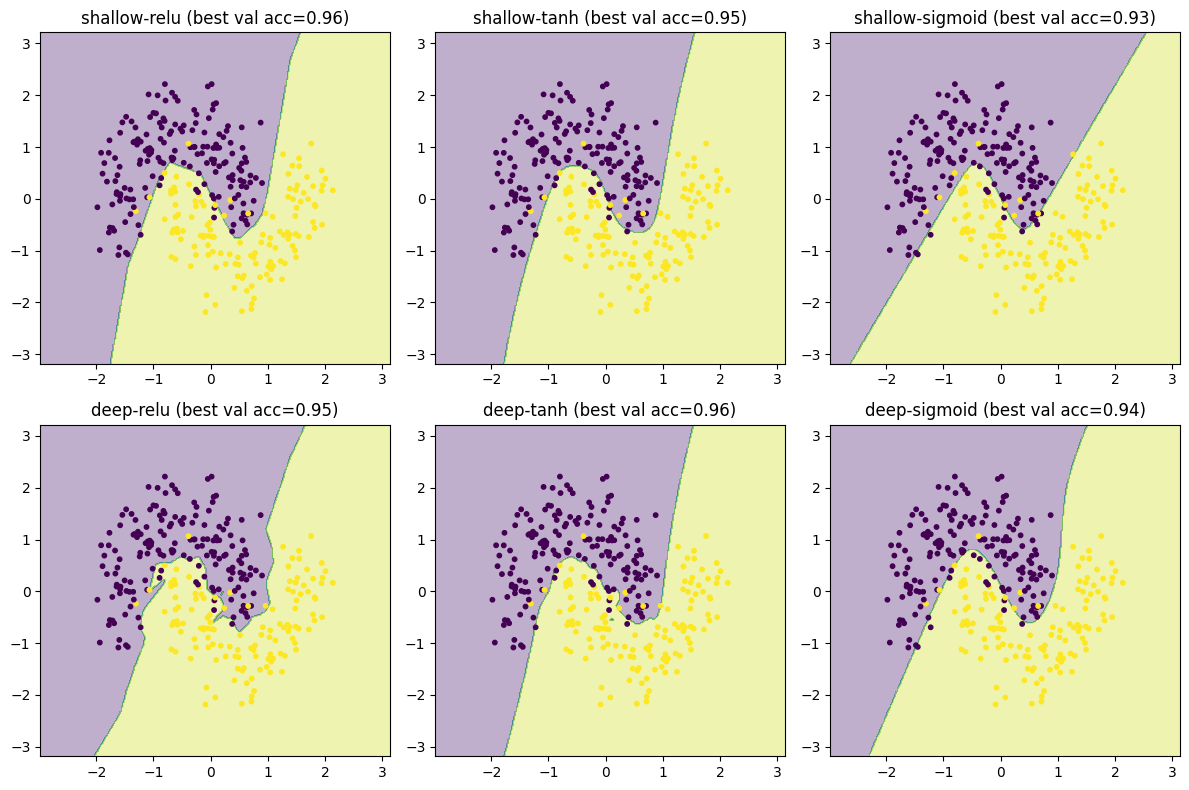

In [4]:
activations = ['relu','tanh','sigmoid']
histories = {}
models_acts = []
titles_acts = []
for depth in ['shallow','deep']:
    for act in activations:
        m = build_model(depth=depth, activation=act, input_dim=X_train.shape[1])
        h = train_with_keras(m, X_train, y_train, optimizer='adam', lr=1e-2, epochs=300, batch_size=64, val_data=(X_test,y_test))
        histories[(depth,act)] = h
        models_acts.append(m)
        titles_acts.append(f"{depth}-{act} (best val acc={max(h.history['val_accuracy']):.2f})")

plt.figure(figsize=(8,5))
for (depth, act), h in histories.items():
    plt.plot(h.history['val_accuracy'], label=f"{depth}-{act}")
plt.title('Validation Accuracy — depth vs activation (Keras)')
plt.xlabel('Epoch'); plt.ylabel('Val Acc'); plt.legend(); plt.show()

plot_grid(models_acts, titles_acts, X_test, y_test, ncols=3, figsize=(12,8))


## 5) Optimizer comparison (GradientTape) — shallow & deep

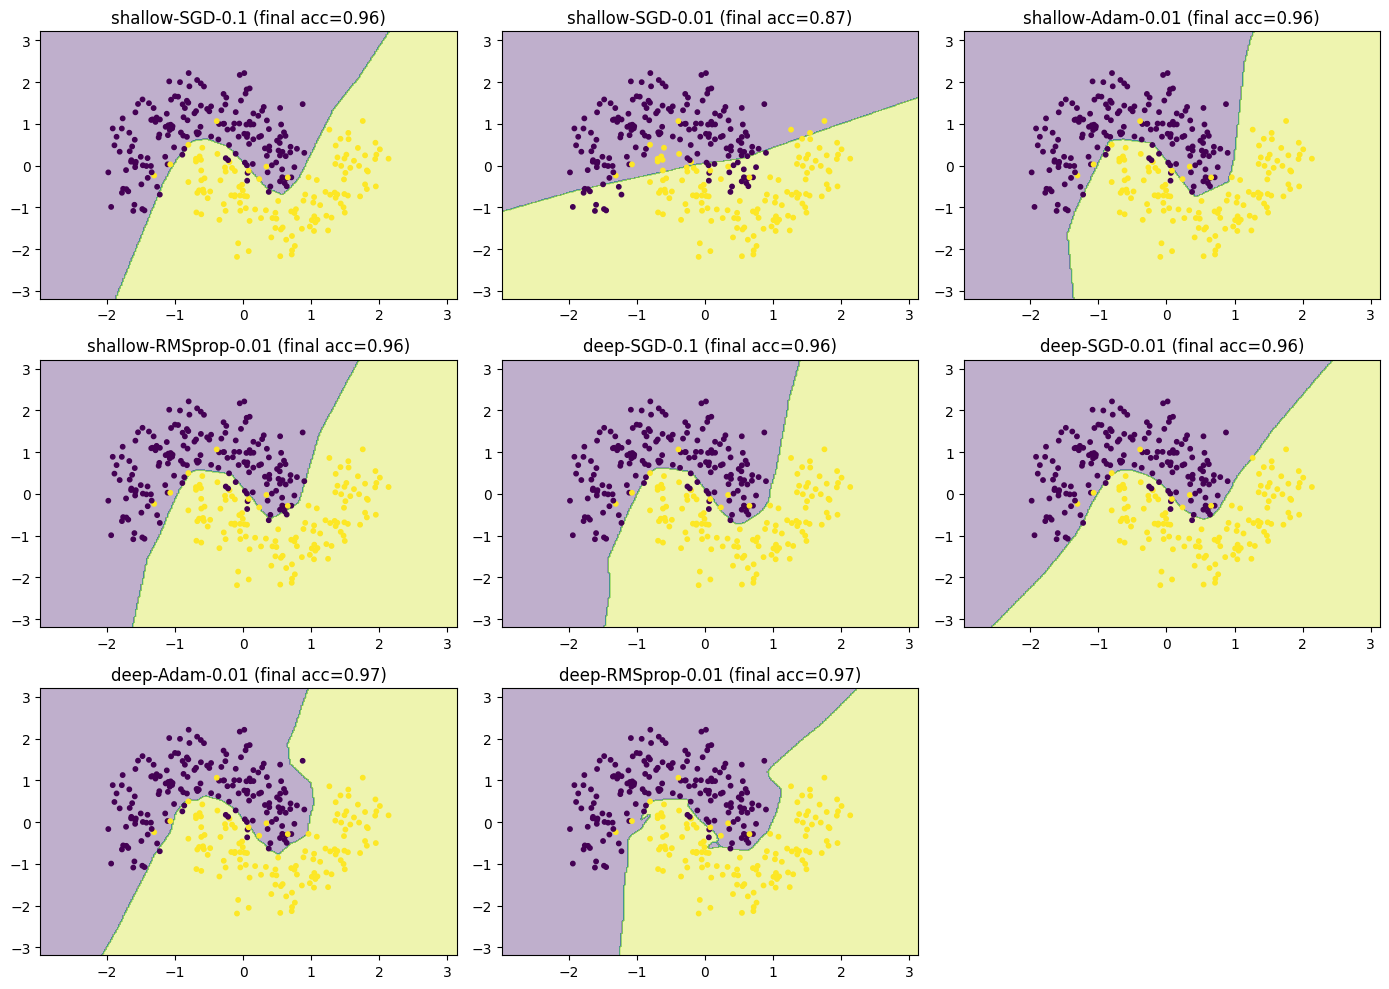

In [7]:
# Fresh optimizer factory so each model gets its own optimizer instance
opt_factories = {
    'SGD-0.1':    lambda: tf.keras.optimizers.SGD(learning_rate=0.1),
    'SGD-0.01':   lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
    'Adam-0.01':  lambda: tf.keras.optimizers.Adam(learning_rate=0.01),
    'RMSprop-0.01': lambda: tf.keras.optimizers.RMSprop(learning_rate=0.01),
}

models_opts, titles_opts = [], []
for depth in ['shallow','deep']:
    for name, make_opt in opt_factories.items():
        m = build_model(depth=depth, activation='relu', input_dim=X_train.shape[1])
        opt = make_opt()                      # NEW: create a new optimizer per model
        hist = train_with_tape(m, X_train, y_train, optimizer=opt, epochs=300, batch_size=64)
        models_opts.append(m)
        titles_opts.append(f"{depth}-{name} (final acc={hist['acc'][-1]:.2f})")

plot_grid(models_opts, titles_opts, X_test, y_test, ncols=3, figsize=(14,10))

